### Manifold Mixup for Speaker Verification

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

#### I. Methold

1. Manifold Mixup Schemes

* Input Mixup
* Medium Mixup
* Embeddings Mixup   ---- Dummy Classifiers ?

2. Domain Mixup



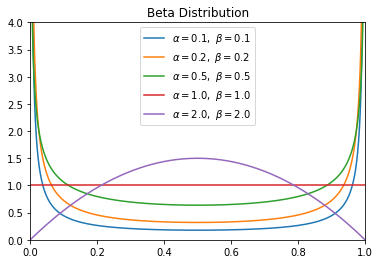

In [44]:
plt.figure(figsize=(6, 4))

ab_pairs = [(0.1, 0.1), (0.2, 0.2), (0.5, 0.5), (1, 1), (2, 2)]
x = np.linspace(0, 1, 1002)[1:-1]
for a, b in ab_pairs:
    # print(a,b)
    dist= beta(a, b)
    y = dist.pdf(x)
    plt.plot(x, y, label=r'$\alpha=%.1f,\ \beta=%.1f$'%(a, b))
plt.title(u'Beta Distribution')
plt.xlim(0,1)
plt.ylim(0,4)
plt.legend()

# plt.savefig("./beta.png", format="png")

#### II. Experiment

1. Comparison of $\alpha, \beta$  in Beta Distribution 

* Training set: VoxCeleb1

| System      |  Beta(alpha)  |       Testset     |     EER     |    MinDCF08   |    MinDCF10   |
| :---------- | :-----------: | :---------------: | ----------: | ------------: | ------------: |
|  ResNet34   |   baseline    |     vox1-test     |  3.66±0.08  | 0.3703±0.0248 | 0.4460±0.0231 |
|     0.1     |      0.1      |     vox1-test     |  4.05±0.04  | 0.3961±0.0076 | 0.4839±0.0299 |
|     0.2     |      0.2      |     vox1-test     |  4.09±0.05  | 0.3876±0.0100 | 0.5330±0.0131 |
|     0.5     |      0.5      |     vox1-test     |  4.26±0.04  | 0.4033±0.0139 | 0.4873±0.0125 |
|     1.0     |      1.0      |     vox1-test     |  4.26±0.04  | 0.4033±0.0139 | 0.4873±0.0125 |
|     2.0     |      2.0      |     vox1-test     |  4.26±0.04  | 0.4033±0.0139 | 0.4873±0.0125 |


2. Comparison of Mixup Layers 

* Training set: VoxCeleb1

| System      |  Description  |       Testset     |     EER     |    MinDCF08   |    MinDCF10   |
| :---------- | :-----------: | :---------------: | ----------: | ------------: | ------------: |
|  ResNet34   |   baseline    |     vox1-test     |  3.66±0.08  | 0.3703±0.0248 | 0.4460±0.0231 |
|     {0}     |               |     vox1-test     |  4.05±0.04  | 0.3961±0.0076 | 0.4839±0.0299 |
|    {0,1}    |               |     vox1-test     |  4.09±0.05  | 0.3876±0.0100 | 0.5330±0.0131 |
|   {0,1,2}   |               |     vox1-test     |  4.26±0.04  | 0.4033±0.0139 | 0.4873±0.0125 |


2. Validation on Large-Scale Dataset

* Training set: VoxCeleb2

| System      |  Description  |       Testset     |     EER     |    MinDCF08   |    MinDCF10   |
| :---------- | :-----------: | :---------------: | ----------: | ------------: | ------------: |
|  ResNet34   |    baseline   |     vox1-test     |  3.66±0.08  | 0.3703±0.0248 | 0.4460±0.0231 |
|             |     Input     |     vox1-test     |  4.25±0.10  | 0.3914±0.0040 | 0.5287±0.0207 |
|             |   manifold    |     vox1-test     |  4.05±0.04  | 0.3961±0.0076 | 0.4839±0.0299 |
|             |               |     vox1-test     |  4.09±0.05  | 0.3876±0.0100 | 0.5330±0.0131 |
|             |               |     vox1-test     |  4.26±0.04  | 0.4033±0.0139 | 0.4873±0.0125 |
|    ECAPA    |               |     vox1-test     |  3.66±0.08  | 0.3703±0.0248 | 0.4460±0.0231 |
|             |      Input    |     vox1-test     |  4.25±0.10  | 0.3914±0.0040 | 0.5287±0.0207 |
|             |   manifold    |     vox1-test     |  4.05±0.04  | 0.3961±0.0076 | 0.4839±0.0299 |
|             |               |     vox1-test     |  4.09±0.05  | 0.3876±0.0100 | 0.5330±0.0131 |
|             |               |     vox1-test     |  4.26±0.04  | 0.4033±0.0139 | 0.4873±0.0125 |
 




In [30]:
mixup,cls_aug = [], []

with open('../data/vox1_cls_mixup.txt', 'r') as f:
    for l in f.readlines():
        lines = l.split(' ')#| 11.65±0.10 | 0.7656±0.0158 | 0.8312±0.0144 | 9.6848±0.2301 | 7.4172±0.3050 | Mean_batch64_cbam_downk1_avg4_SAP2_em128_dp01_alpha1_none1_wd5e4_mix2_dist_128-baselin
        eer = float(lines[1].split('±')[0])
        if 'baseline' in lines[-1]:
            baseline = eer
        elif 'clsaug' in lines[-1]:
            cls_aug.append(eer)
        else:
            mixup.append(eer)

Text(0, 0.5, 'EER (%)')

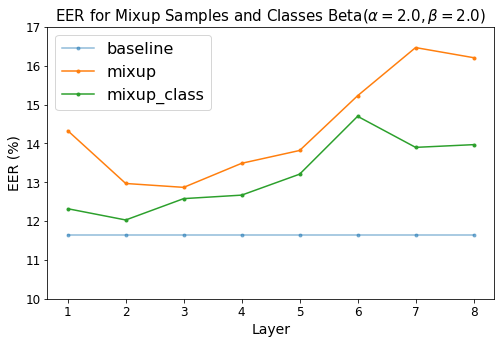

In [43]:
fig = plt.figure(figsize=(8, 5))
plt.title(u'EER for Mixup Samples and Classes Beta($\\alpha=2.0,\\beta=2.0$)', fontsize=15)

x = np.arange(1,9)
plt.plot(x, [baseline]*len(x), marker='.', alpha=0.5)
plt.plot(x, mixup, marker='.')
plt.plot(x, cls_aug, marker='.')
plt.legend(['baseline', 'mixup', 'mixup_class'], fontsize=16)
plt.ylim([10, 17])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel('Layer', fontsize=14)
plt.ylabel('EER (%)', fontsize=14)